In [ ]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# new import statements
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

import numpy as np

# Regression 2

In [ ]:
# Do not reptitivitely download large datasets
# Save a local copy instead
dataset_file = "covid.geojson"
if os.path.exists(dataset_file):
    print("Reading local file.")
    df = gpd.read_file(dataset_file)
else:
    print("Downloading the dataset.")
    url = "https://dhsgis.wi.gov/server/rest/services/DHS_COVID19/COVID19_WI_V2/MapServer/9/query?outFields=*&where=1%3D1&f=geojson"
    df = gpd.read_file(url)
    df.to_file(dataset_file)

### Predicting "DTH_CUM_CP"

In [ ]:
df = df.replace(-999, 2)
# Removing outlier point
df = df[df["GEOID"].str.fullmatch(r"\d+")]

#### Did our model learn, or just memorize (that is, "overfit")?

- Split data into train and test

#### `train_test_split(<dataframe>, test_size=<val>)`

- requires `from sklearn.model_selection import train_test_split`
- shuffles the data and then splits based on 75%-25% split between train and test
    - produces new train and test data every single time
- `test_size` parameter can take two kind of values:
    - actual number of rows that we want in test data
    - fractional number representing the ratio of train versus test data
    - default value is `0.25`
- documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
xcols = ["POP"]
ycol = "DTH_CUM_CP"

In [ ]:
train, test = train_test_split(df)

# Let's use the train and the test data
model = LinearRegression()
# Fit using training data
model.fit(train[xcols], train[ycol])
# Predict using test data
y = model.predict(test[xcols])
# We can use score directly as it automatically invokes predict
model.score(test[xcols], test[ycol])

Running the above cell again will give you entirely different model and score.

#### How can we minimize noise due to random train/test splits?

### Cross validation: `cross_val_score(estimator, X, y)`

- requires `from sklearn.model_selection import cross_val_score`
-  do many different train/test splits of the values, fitting and scoring the model across each combination
- cross validation documentation: https://scikit-learn.org/stable/modules/cross_validation.html
- function documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [ ]:
train, test = train_test_split(df)

model = LinearRegression()
scores = cross_val_score(???)
scores

In [ ]:
# Compute mean of the scores
scores.mean()

#### How can we compare models?
- model 1: POP => DEATHS
- model 2: CASES (POS_CUM_CP) => DEATHS

In [ ]:
model1 = LinearRegression()
model2 = LinearRegression()
model1_scores = cross_val_score(model1, train[["POP"]], train[ycol])
model2_scores = cross_val_score(model2, train[["POS_CUM_CP"]], train[ycol])

In [ ]:
model1_scores.mean()

In [ ]:
model2_scores.mean()

Which of these two models do you think will perform better? Probably model2.

In [ ]:
means = pd.Series({"model1": model1_scores.mean(),
                   "model2": model2_scores.mean()})
means.plot.bar(figsize=(3, 3))

How do we know the above difference is not noise? Let's calculate standard deviation and display error bars on the bar plot.

In [ ]:
model1_scores.std()

In [ ]:
model2_scores.std()

In [ ]:
err = pd.Series({"model1": model1_scores.std(),
                 "model2": model2_scores.std()})
err

In [ ]:
# Plot error bar by passing argument to paramenter yerr
means.plot.bar(figsize=(3, 3))

Pick a winner and run it one more time against test data.

#### How can we use multiple x variables (multiple regression)?

- Features: Positive cases per age range

In [ ]:
df.columns

In [ ]:
xcols = ['POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP', 'POS_30_39_CP',
       'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP', 'POS_70_79_CP',
       'POS_80_89_CP', 'POS_90_CP']
ycol = "DTH_CUM_CP"

model = LinearRegression()
model.fit(train[xcols], train[ycol])
model.score(test[xcols], test[ycol]) 

#### How can we interpret what features the model is relying on?

In [ ]:
pd.Series(model.coef_)

In [ ]:
pd.Series(model.coef_, index=???).plot.bar(figsize=(3, 2))

<div>
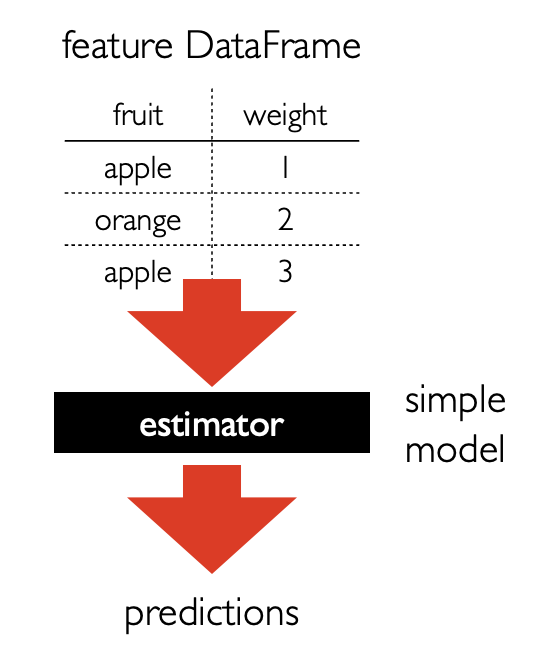
</div>

### Lake Michigan Waves

Source: https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku

In [ ]:
df = pd.read_csv("waves.csv")
df.head()

In [ ]:
df.columns

#### Can we predict wave height based on wave period (time between waves)?

In [ ]:
df = df[(df["Wave Period"] > 0) & (df["Wave Height"] > 0)]
df.plot.scatter(x="Wave Period", y="Wave Height", color="k", alpha=0.05)

Observation: non-linear relationship => fitting straight line will not work.

#### Can we predict wave height based on beach name and wave period?

In [ ]:
beach_names = sorted(set(df["Beach Name"]))
beach_names

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace=0.3)
axes = list(axes.reshape(-1))
for b in beach_names:
    ax = axes.pop(0)
    ax.set_title(b)
    beach_df = df[df["Beach Name"] == b]
    beach_df.plot.scatter(x="Wave Period", y="Wave Height", 
                          color="k", alpha=0.1, ax=ax)


Obversation: which beach (categorical feature) is important.

### Four Models

1. wave period (linear)
2. wave period (polynomial)
3. beach
4. beach and wave period

`train_test_split(<dataframe>, random_state=<some number>)`
- `random_state` enables us to control the randomization
- when we pass the same number, we will get the same training and test data (psuedo randomization)

In [ ]:
train, test = train_test_split(df, random_state=320)
train.head()

#### Model 1: Wave Period (Linear)

`cross_val_score(estimator, X, y, cv=<number>)`
- `cv` enables us mention how many folds we want for the cross-validation

In [ ]:
xcols = ["Wave Period"]
ycol = "Wave Height"

m1 = ???
scores = ???
scores

In [ ]:
scores.mean()

We want the mean score to be large.

In [ ]:
scores.std()

We want the standard deviation to be small, to make sure that our model isn't too sensitive to changes in training and test data.

#### Model 2: Wave Period (Polynomial)

LinearRegression can do this:

```
y = 3*x1 + 5*x2
```
It CANNOT do this:
```
y = 3*x + 5*x^2
```
TRICK:
```
x1 = x
x2 = x^2
```

<div>
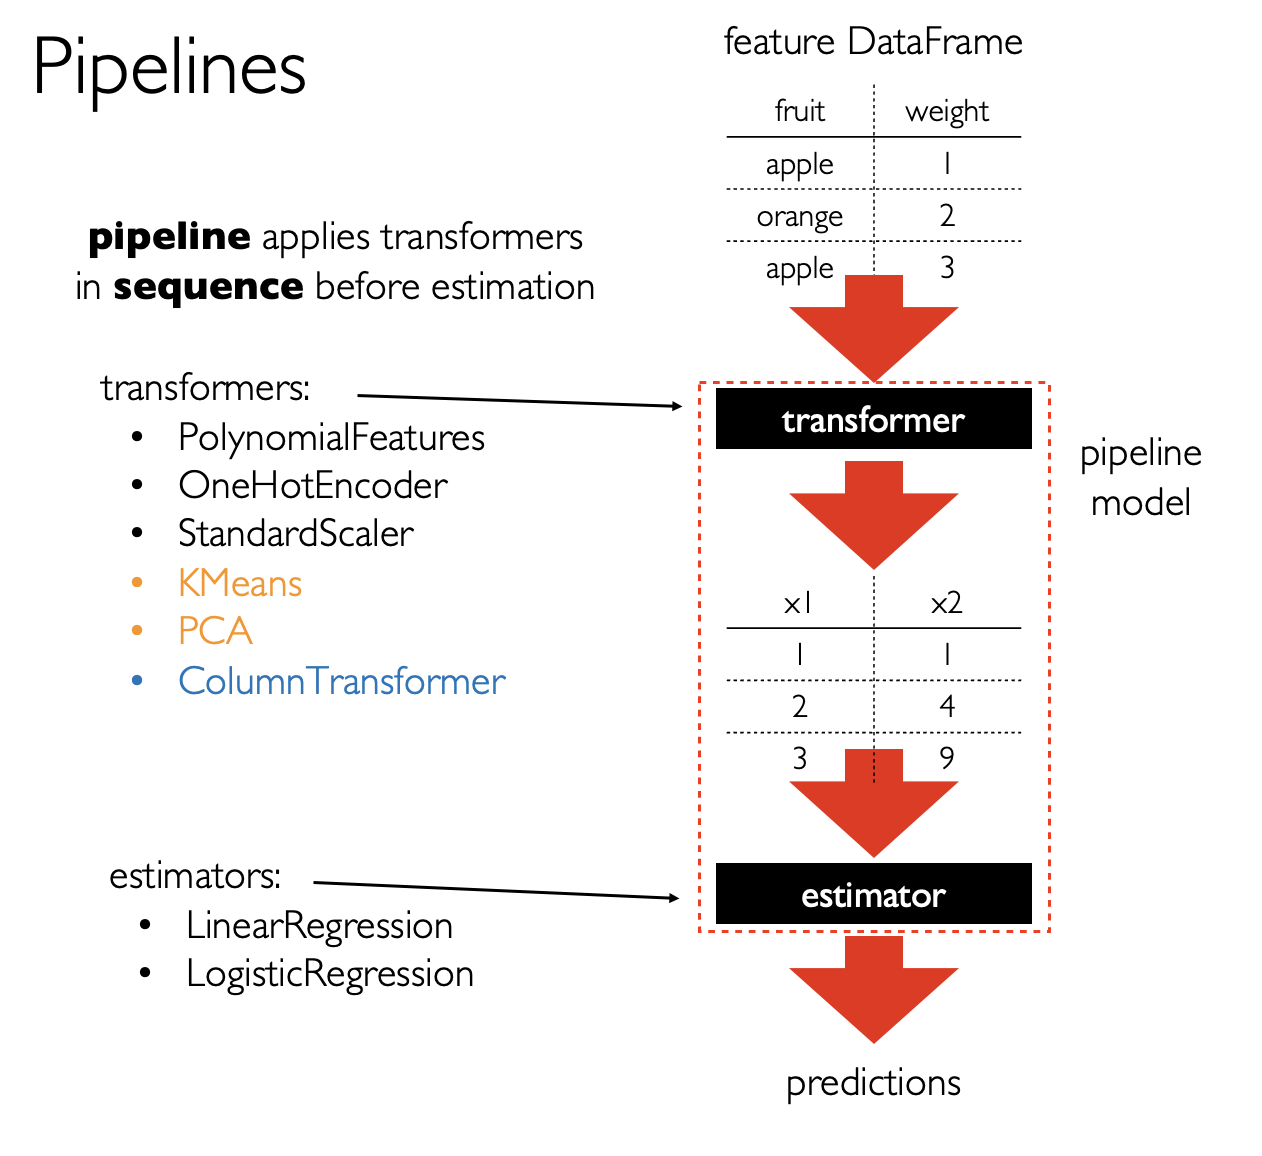
</div>

In [ ]:
# Let's make a copy before we add new columns
# Recommendation: don't change the data referred to by a specific variable 
# throughout your code

train2 = train[xcols].copy()
train2.head()

Manually adding columns for x^2, x^3, etc.,

In [ ]:
train2["Wave Period ^ 2"] = train2["Wave Period"] ** 2
train2["Wave Period ^ 3"] = train2["Wave Period"] ** 3
train2["sqrt(Wave Period"] = train2["Wave Period"] ** 0.5
train2.head()

#### `PolynomialFeatures(degree=<val>, include_bias=False)`

- `degree` enables us to mention how many degrees we need
- `include_bias` default value is True, which will add a column of 1s - we typically don't use that.
- returns an object instance on which we can invoke `fit` and `transform`:
    - `transform(X, columns=<col names>)`: transform data to polynomial features`
    - `fit_transform(X[, y])`: fit to data, then transform it.
- documentation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [ ]:
pf = 

In [ ]:
# Fit the data
pf

In [ ]:
# Transform the data
pf

In [ ]:
# Convert result of transformation into a DataFrame - step 1
pd.DataFrame(pf.transform(train[xcols]))

How can we add meaningful column names? `pf.get_feature_names_out()`

In [ ]:
pf

In [ ]:
# Convert result of transformation into a DataFrame - step 2
pd.DataFrame(pf.transform(train[xcols]), columns=???)

In [ ]:
# Putting all the steps together
pf = PolynomialFeatures(degree=4, include_bias=False)
pf.fit(train[xcols])
pd.DataFrame(pf.transform(train[xcols]), columns=pf.get_feature_names_out()).head()

`fit_transform(X[, y])`: fit to data, then transform it.

In [ ]:
new_data = ???
pd.DataFrame(new_data, columns=pf.get_feature_names_out()).head()

#### `Pipeline(...)`

- Argument: list of steps in the pipeline:
    - each step represented as a tuple with name of the step and the object instance
    - last step will be the estimator
- documention: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [ ]:
m2 = Pipeline([
    #PolynomialFeatures(degree=2, include_bias=False)
    # LinearRegression()
])
m2

In [ ]:
scores = cross_val_score(m2, train[xcols], train[ycol], cv=10)
scores.mean()

**Conclusion:** mean R^2 score increased from 0.0029 (linear model) to 0.0489 (polynomial) - not bad!

#### Model 3: Beach Name (Categorical)

In [ ]:
train["Beach Name"].unique()

Naive way of assigning numerial values to a categorical column:
- `Ohio Street Beach`: 1
- `Calumet Beach`: 2
- `Rainbow Beach`: 3, etc.,
- Problem: `Calumet Beach` will become an average of `Ohio Street Beach` and `Rainbow Beach` => this doesn't make any sense!

#### `OneHotEncoder()`

- encodes categorical features as a one-hot numeric array
- returns a "sparse matrix", which needs to be explicitly converted into an `array` using `to_array()` method, before `DataFrame` conversion
- documention: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [ ]:
xcols = ["Beach Name"]

In [ ]:
# fit_transform


In [ ]:
# All steps
oh = OneHotEncoder()
pd.DataFrame(oh.fit_transform(train[xcols]).toarray(), columns=oh.get_feature_names_out())

In [ ]:
m3 = Pipeline([
    ("oh", OneHotEncoder()),
    ("lr", LinearRegression())
])
m3

In [ ]:
scores = cross_val_score(m3, train[xcols], train[ycol], cv=10)
scores.mean()

**Conclusion:** mean R^2 score is slightly lower than 0.0489 (polynomial).

<div>
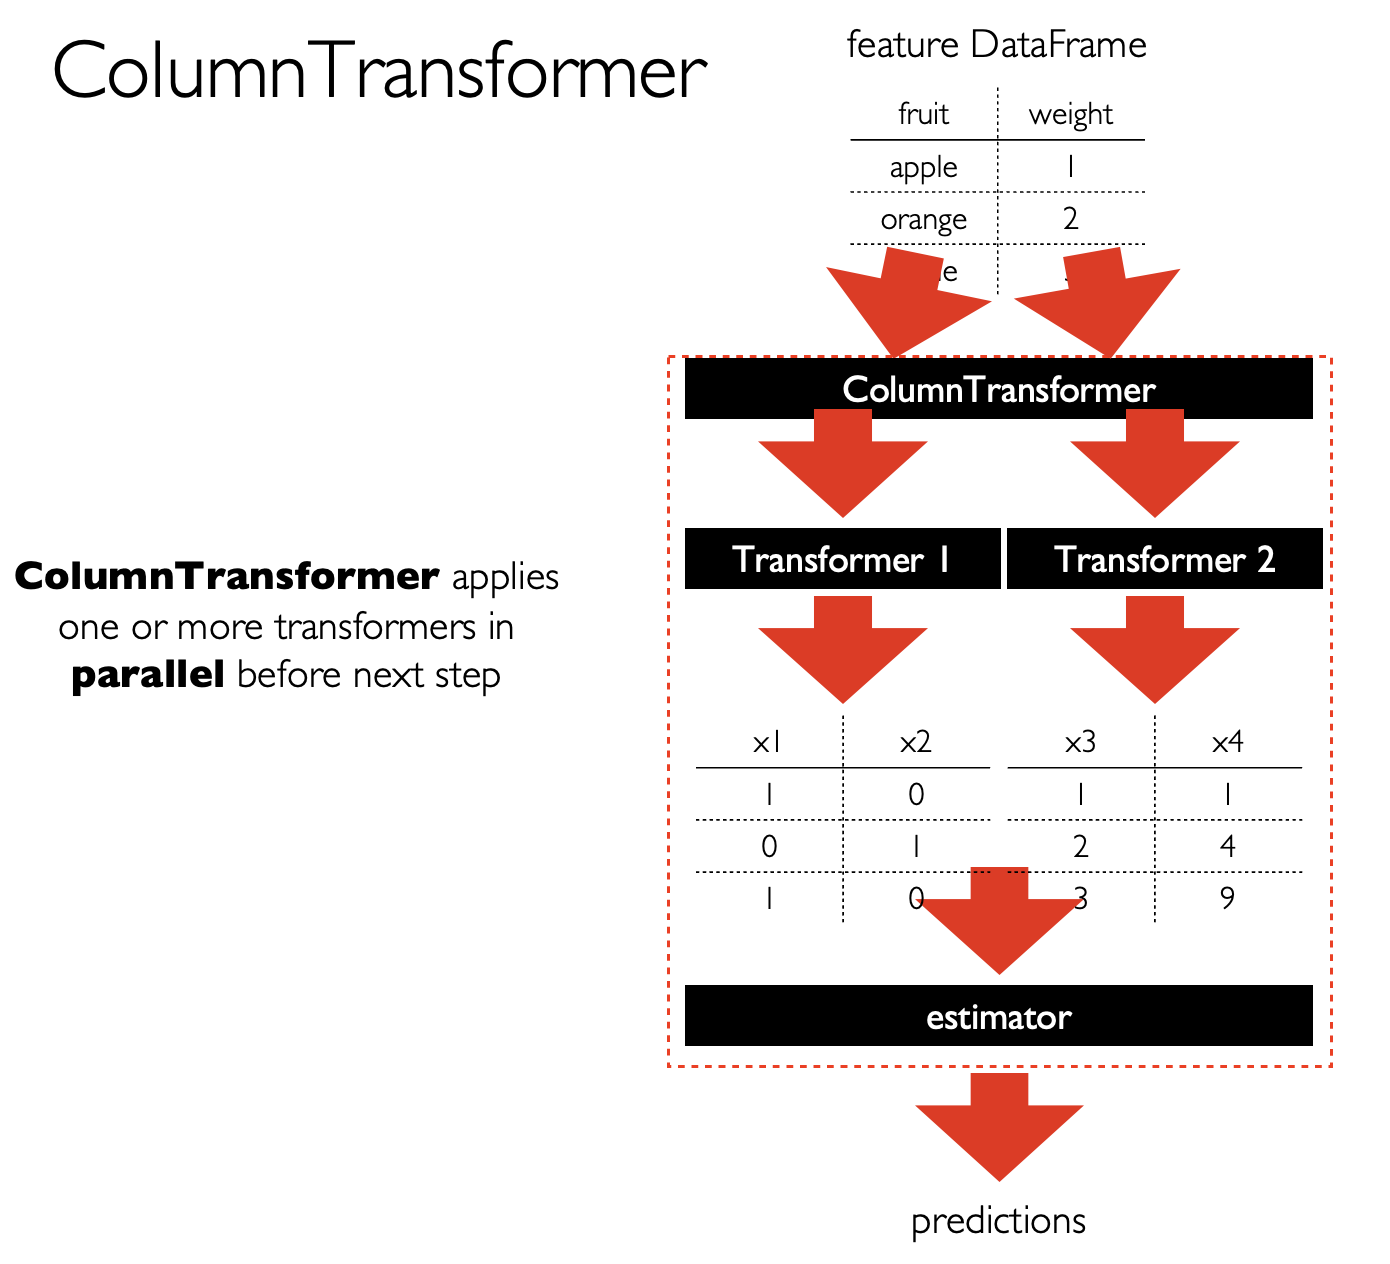
</div>

#### `make_column_transformer(...)`

- Argument: transformations
    - each transformer argument will be a `tuple` with object instance as first item and list of feature columns as the second
- documention: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html

#### Model 4: Beach Name (Categorical) and Wave Period (Polynomial)

In [ ]:
custom_trans = make_column_transformer(
    (PolynomialFeatures(), ["Wave Period"]),
    (OneHotEncoder(), ["Beach Name"]),
)
custom_trans

In [ ]:
m4 = Pipeline([
    ("transformers", custom_trans),
    ("lr", LinearRegression()),
])
m4

In [ ]:
xcols = ["Beach Name", "Wave Period"]

In [ ]:
scores = cross_val_score(m4, train[xcols], train[ycol], cv=10)
scores.mean()

**Conclusion:** mean R^2 score increased to 0.0885 when compared to 0.0489 (polynomial).

### Let's evaluate this model by running it against the test data

In [ ]:
m4.fit(train[xcols], train[ycol])
m4.score(test[xcols], test[ycol])

How to extract `coef_` for this `Pipeline`?

In [ ]:
m4["transformers"].get_feature_names_out()

In [ ]:
m4["lr"].coef_

In [ ]:
s = pd.Series(m4["lr"].coef_, index=m4["transformers"].get_feature_names_out())
s.plot.barh()